# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание признаков**

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

**План работы**:

1. Подготовка данных:
    1. Загрузить исходные данные.
    1. Проверить корректность типов столбцов исходных данных.
    1. Удалить нерелевантные для оценки рыночной стоимости авто данные.
    1. Посмотреть на распределение данных и выявить аномалии.
1. Подготовка выборок для обучения моделей.
1. Обучение и анализ разных моделей:
    1. Дерево решений
    1. Случайный лес
    1. Градиентный бустинг
1. Выбор наилучшей модели на основе RMSE и скоростей обучения и предсказания.

## Подготовка данных

### Импорт данных и библиотек

In [1]:
# импорт библиотек для работы
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

In [3]:
# загрузим файл с данными
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    # здесь была загрузка данных с Яндекса

### Изучение данных

In [4]:
data.shape

(354369, 16)

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

### Обработка дубликатов

In [9]:
# проверим наличие полных дубликатов в таблице
data.duplicated().sum()

4

In [10]:
# удалим дубликаты из датасета, сбросив индексы
data = data.drop_duplicates().reset_index(drop=True)

data.duplicated().sum()

0

### Удаление неинформативных столбцов

Вероятнее всего, столбцы `DateCrawled`, `DateCreated`, `DateCreated` можно удалить, т.к. они касаются сбора данных, а не самих машин. Посмотрим на гистограммы и убедимся в том, что данные несильно разбросаны и действительно касаются сбора информации.

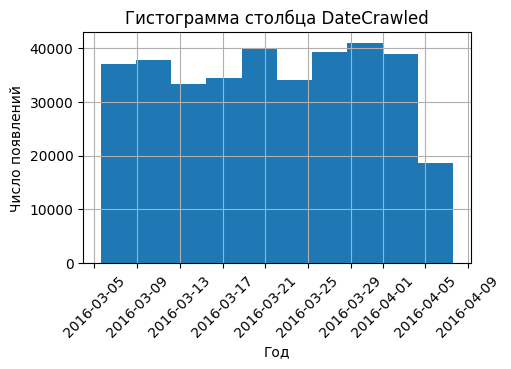

In [11]:
data['DateCrawled'].hist(xrot=45, figsize=(5,3))
plt.title('Гистограмма столбца DateCrawled')
plt.xlabel('Год')
plt.ylabel('Число появлений')
plt.show()

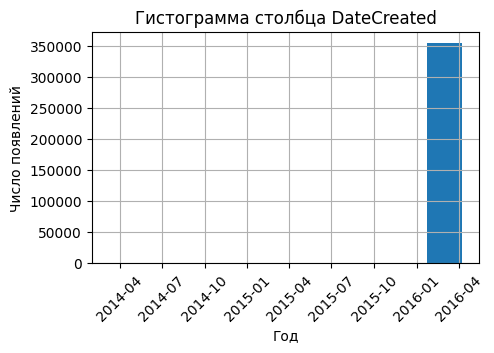

In [12]:
data['DateCreated'].hist(xrot=45, figsize=(5,3))
plt.title('Гистограмма столбца DateCreated')
plt.xlabel('Год')
plt.ylabel('Число появлений')
plt.show()

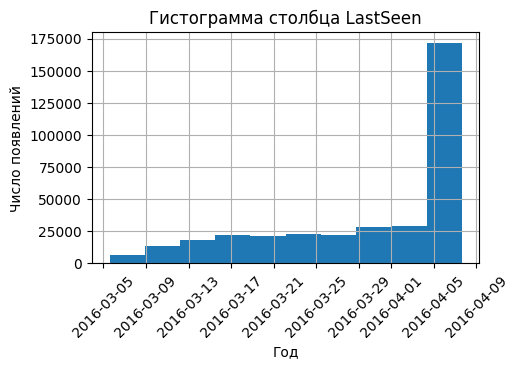

In [13]:
data['LastSeen'].hist(xrot=45, figsize=(5,3))
plt.title('Гистограмма столбца LastSeen')
plt.xlabel('Год')
plt.ylabel('Число появлений')
plt.show()

Удалим эти столбцы.

In [14]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])

In [15]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


Столбец `PostalCode` не поможет в определении стоимости автомобиля - вероятнее всего он попал в базу как характеристика продавца, следовательно, можем удалить этот столбец.

In [16]:
data = data.drop(columns=['PostalCode'])

Посмотрим на распределение числа изображений (столбец `NumberOfPictures`):

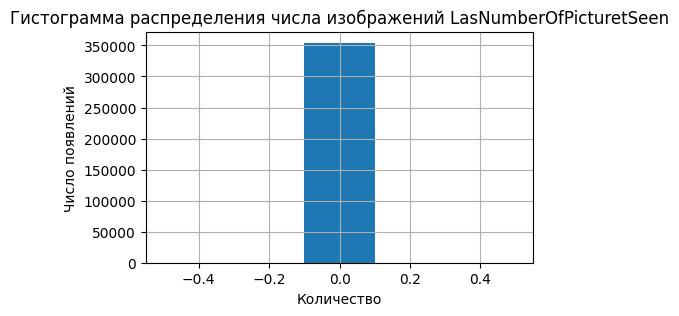

In [17]:
data['NumberOfPictures'].hist(bins=5, figsize=(5,3))
plt.title('Гистограмма распределения числа изображений LasNumberOfPicturetSeen')
plt.xlabel('Количество')
plt.ylabel('Число появлений')
plt.show()

In [18]:
data['NumberOfPictures'].unique()

array([0])

Данный столбец тоже можно удалить из модели, т.к. все автомобили продаются без фото.

In [19]:
data = data.drop(columns=['NumberOfPictures'])

Месяц регистрации автомобиля является неинформативным признаком, который также можно удалить. Он не характеризует сам автомобиль.

In [20]:
data = data.drop(columns=['RegistrationMonth'])

In [21]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Обработка заголовков столбцов

Приведем, наконец, названия столбцов к змеиному регистру:

In [22]:
data.columns = data.columns.str.lower()

In [23]:
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [24]:
# переименуем оставшиеся столбцы
data = data.rename({'vehicletype': 'vehicle_type', 
                    'registrationyear': 'registration_year', 
                    'registrationmonth': 'registration_month',
                    'fueltype': 'fuel_type'}, axis=1)

In [25]:
# посмотрим, что получилось
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Такой вид заголовков является более читабельным и с ним удобнее работать.

### Обработка пропусков

In [26]:
# проверим количество пропусков в процентах
pd.DataFrame(round(data.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
fuel_type,9.000000
brand,0.000000
repaired,20.000000


Начнем с признака `repaired`: поскольку машина либо восстановлена, либо нет, при отсутствии данной информации ее невозможно восстановить, в связи с чем лучше всего заменить пропуски на заглушку `unknown`.

In [27]:
# добавим заглушку unknown в repaired
data.loc[data['repaired'].isna(), 'repaired'] = 'unknown'

In [28]:
# проверим количество пропусков в процентах
pd.DataFrame(round(data.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
fuel_type,9.000000
brand,0.000000
repaired,0.000000


В таблице остались пропуски по столбцам `vehicle_type`, `gearbox`, `model`, `fuel_type`. Это достаточно важные признаки, влияющие на формирование стоимости автомобиля, поэтому обойтись без них сложно, однако выкидывать такое количество данных не хочется, т.к. мы уже отбросили некоторый объем данных из-за аномалий, поэтому заполним пропуски в категориальных признаках после разбиения данных на обучающую, валидационную и тестовую выборки наиболее часто встречающимся при помощи метода `.mode()`.

Во избежание утечки данных дальнейшую обработку пропусков, а также обработку аномалий мы будем производить только на обучающей выборке.

**Разбиение данных на обучающую, валидационную и тестовую выборки**

In [29]:
# разобьем данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1

# поделим данные на обучающую (80%) и тестовую выборки (20%)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

# поделим обучающую выборку на обучающую и валидационную выборки в соотношении 3:1
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=RANDOM_STATE)

In [30]:
# посмотрим размеры полученных выборок
print(data_train.shape, data_test.shape, data_valid.shape, sep='\n')

(212619, 10)
(70873, 10)
(70873, 10)


Разбиение было произведено корректно.

Добавим пользовательскую функцию, которая будет по моде заменять пропуски в столбце по наиболее популярному значению в другом столбце:

In [31]:
def fillna_with_mode(dataframe, find_here, change_here):
    
    for i in dataframe[find_here].unique():
        
        # если есть хоть одно соответствующее значение, меняем на моду
        if len(dataframe.loc[dataframe[find_here] == i, change_here].mode()) > 0: 
            dataframe.loc[
                (dataframe[find_here] == i) & (dataframe[change_here].isna()), 
                change_here
            ] = dataframe.loc[dataframe[find_here] == i, change_here].mode()[0]
            
        # если менять не на что, пишем 'other'
        else:
            dataframe.loc[
                (dataframe[find_here] == i) & (dataframe[change_here].isna()), 
                change_here
            ] = 'other'

In [32]:
# заменим пропуски в моделях по наиболее популярной модели каждого бренда
fillna_with_mode(data_train, 'brand', 'model')

In [33]:
# заменим пропуски в коробке передач по наиболее популярной коробке передач каждой модели
fillna_with_mode(data_train, 'model', 'gearbox')

In [34]:
# заменим пропуски в типе топлива по наиболее популярному типу топлива каждой модели
fillna_with_mode(data_train, 'model', 'fuel_type')

In [35]:
# заменим пропуски в кузовах по наиболее популярному кузову каждой модели
fillna_with_mode(data_train, 'model', 'vehicle_type')

Посмотрим теперь на число пропусков в данных:

In [36]:
# проверим количество пропусков в процентах в обучающей выборке
pd.DataFrame(round(data_train.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


Применим ту же самую функцию к валидационной и тестовой выборке.

In [37]:
# валидационная выборка

# заменим пропуски в моделях по наиболее популярной модели каждого бренда
fillna_with_mode(data_valid, 'brand', 'model')
# заменим пропуски в коробке передач по наиболее популярной коробке передач каждой модели
fillna_with_mode(data_valid, 'model', 'gearbox')
# заменим пропуски в типе топлива по наиболее популярному типу топлива каждой модели
fillna_with_mode(data_valid, 'model', 'fuel_type')
# заменим пропуски в кузовах по наиболее популярному кузову каждой модели
fillna_with_mode(data_valid, 'model', 'vehicle_type')

In [38]:
# проверим количество пропусков в процентах в валидационной выборке
pd.DataFrame(round(data_valid.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


In [39]:
# тестовая выборка

# заменим пропуски в моделях по наиболее популярной модели каждого бренда
fillna_with_mode(data_test, 'brand', 'model')
# заменим пропуски в коробке передач по наиболее популярной коробке передач каждой модели
fillna_with_mode(data_test, 'model', 'gearbox')
# заменим пропуски в типе топлива по наиболее популярному типу топлива каждой модели
fillna_with_mode(data_test, 'model', 'fuel_type')
# заменим пропуски в кузовах по наиболее популярному кузову каждой модели
fillna_with_mode(data_test, 'model', 'vehicle_type')

In [40]:
# проверим количество пропусков в процентах в валидационной выборке
pd.DataFrame(round(data_test.isna().mean() * 100,)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


Таким образом, мы заполнили все пропуски в исходных данных.

### Анализ распределения данных и аномалий

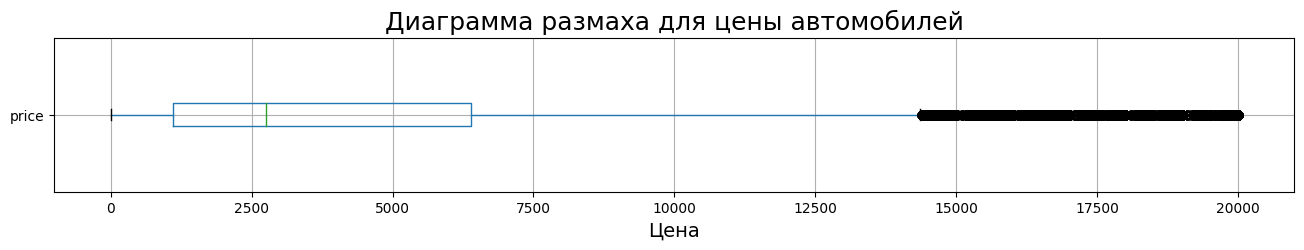

In [41]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='price', vert=False)
ax.set_title('Диаграмма размаха для цены автомобилей', size=18)
ax.set_xlabel('Цена', size=14)
plt.show()

Несмотря на то, что цены некоторых авто находятся вне "усов", их сложно считать аномалиями с т.з. логики, поэтому не будет удалять.
А вот цены авто, равные нулю, надо будет удалить.

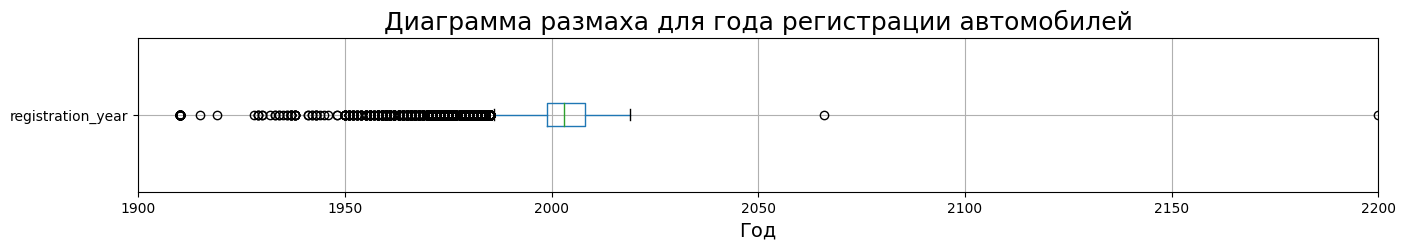

In [42]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='registration_year', vert=False)
ax.set_title('Диаграмма размаха для года регистрации автомобилей', size=18)
ax.set_xlabel('Год', size=14)
plt.xlim(1900, 2200)
plt.show()

По годам очевидно наличие аномалий. Чуть ниже мы отбросим значения.

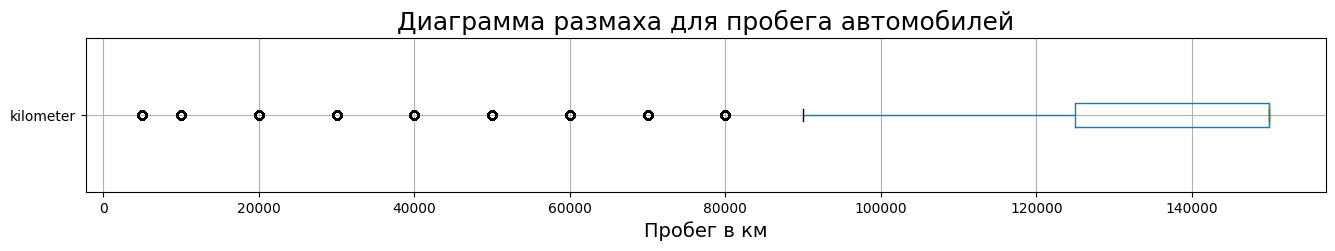

In [43]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='kilometer', vert=False)
ax.set_title('Диаграмма размаха для пробега автомобилей', size=18)
ax.set_xlabel('Пробег в км', size=14)
plt.show()

Здесь отбрасывать автомобили находящиеся вне межквартильного размаха и "усов" нелогично, т.к. их пробег меньше 90 тыс.км, что вполне адекватно и встречается на рынке - это не является аномалией.

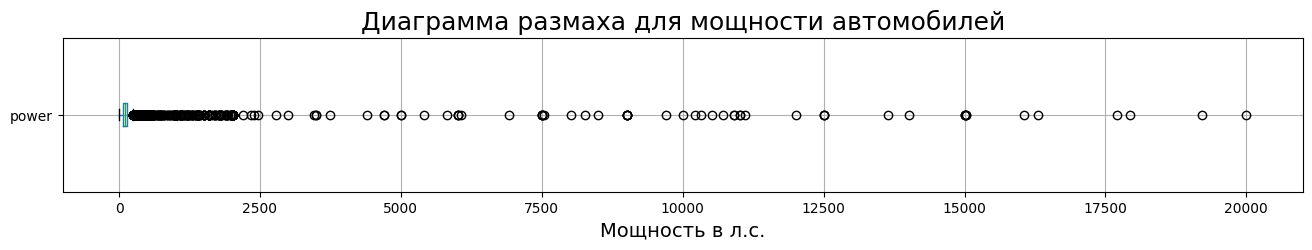

In [44]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='power', vert=False)
ax.set_title('Диаграмма размаха для мощности автомобилей', size=18)
ax.set_xlabel('Мощность в л.с.', size=14)
plt.show()

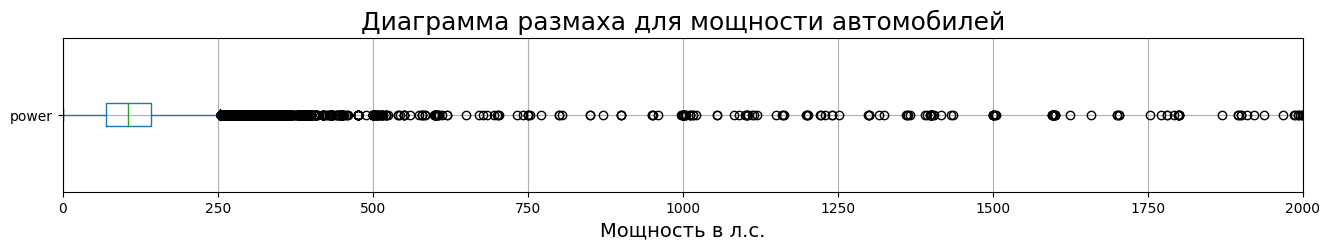

In [45]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='power', vert=False)
ax.set_title('Диаграмма размаха для мощности автомобилей', size=18)
ax.set_xlabel('Мощность в л.с.', size=14)
plt.xlim(0, 2000)
plt.show()

На сегодняшний день в среднем мощности автомобилей доходят до 700-800 л.с. Следовательно, значения больше 800 точно являются аномалиями в данном датасете. 
Также мощности авто в 0 л.с. являются аномалиями, от которых следует избавиться. В целом мощность современных автомобилей начинается от 20 л.с., следовательно эту цифру можно использовать в качестве нижнего порога.

В среднем автомобили имеют мощность до 250 л.с., т.к. свыше 250 л.с. уже облагаются по более высокой ставке, отсюда из диаграммы размаха и видно, что "усы" заканчиваются на 250 л.с. При этом мне кажется целесообразным отбросить автомобили с мощностью ниже 800 л.с., а не 250, т.к. иначе мы потеряем автомобили высокой мощности из выборки.

Посмотрим внимательнее на диаграмму размаха для года регистрации автомобилей.

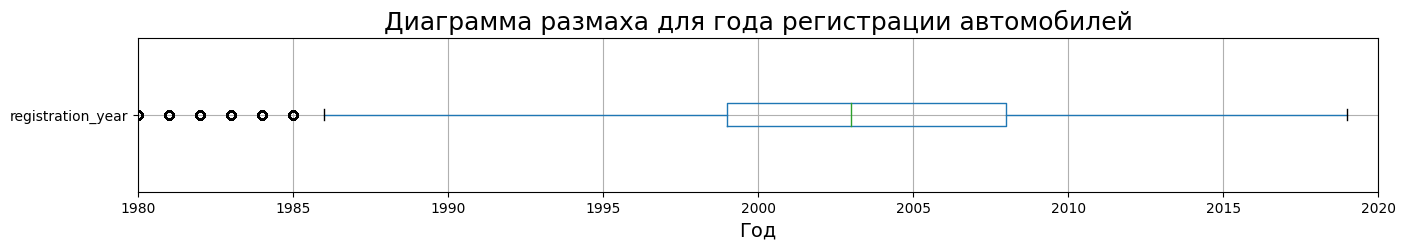

In [46]:
fig, ax = plt.subplots(figsize=(16, 2))
ax = data_train.boxplot(column='registration_year', vert=False)
ax.set_title('Диаграмма размаха для года регистрации автомобилей', size=18)
ax.set_xlabel('Год', size=14)
plt.xlim(1980, 2020)
plt.show()

В целом здесь все адекватно. Будем отбрасывать авто после 2016 года, поскольку данные были выгружены в 2016 году и наличие авто с регистрацией позже является очевидным техническим сбоем:

In [47]:
data_train = data_train.query('registration_year <= 2016')

Отбросим автомобили стоимости 0:

In [48]:
data_train = data_train[data_train['price'] > 0]

Отбросим автомобили с мощностью двигателя меньше 20 л.с. и выше 800 л.с.:

In [49]:
data_train = data_train.query('power > 20 and power < 800')

Скорректируем аномалии на валидационной и тестовой выборках:

In [50]:
data_valid = data_valid.query('registration_year <= 2016')
data_valid = data_valid[data_valid['price'] > 0]
data_valid = data_valid.query('power > 20 and power < 800')

data_test = data_test.query('registration_year <= 2016')
data_test = data_test[data_test['price'] > 0]
data_test = data_test.query('power > 20 and power < 800')

In [51]:
data_train = data_train.reset_index(drop=True)
data_valid = data_valid.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

**Вывод:**<br/>
Таким образом, в данном разделе мы импортировали исходные данные, удалили явные дубликаты, привели заголовки к змеиному регистру, избавились от неинформативных столбцов, обработали аномалии и пропуски в данных. Теперь можно переходить к обучению моделей.

## Обучение моделей

### Подготовка данных к обучению

#### Разбиение данных на признаки и таргет по выборкам

In [52]:
# разобьем обучающую выборку на признаки и таргет
train_target = data_train['price']
train_features = data_train.drop('price', axis=1)

# разобьем валидационную выборку на признаки и таргет
valid_target = data_valid['price']
valid_features = data_valid.drop('price', axis=1)

# разобьем тестовую выборку на признаки и таргет
test_target = data_test['price']
test_features = data_test.drop('price', axis=1)

#### Кодирование категориальных переменных

In [53]:
# выделим категориальные признаки
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# применим порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

encoder.fit(train_features[cat_columns])

train_features[cat_columns] = encoder.transform(train_features[cat_columns])
valid_features[cat_columns] = encoder.transform(valid_features[cat_columns])
test_features[cat_columns] = encoder.transform(test_features[cat_columns])

#### Масштабирование данных

In [54]:
# выделим числовые признаки
num_columns = ['registration_year', 'power', 'kilometer']

# отмасштабируем числовые признаки
scaler = StandardScaler()
scaler.fit(train_features[num_columns])

train_features[num_columns] = scaler.transform(train_features[num_columns])
valid_features[num_columns] = scaler.transform(valid_features[num_columns])
test_features[num_columns] = scaler.transform(test_features[num_columns])

#### Добавление метрики качества

Поскольку в качестве метрики качества необходимо использовать RMSE, добавим следующую пользовательскую функцию для удобства:

In [56]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

### Dummy model

Построим дамми модель по среднему значению, с которой будем сравнивать финальную модель на адекватность.

In [57]:
model = DummyRegressor(strategy='mean')
model.fit(train_features, train_target)
predictions = model.predict(test_features)
dummy_rmse = rmse(test_target, predictions)
dummy_rmse

4608.239345991493

### Decision Tree Regression

In [58]:
# через цикл будем выбирать модель с наименьшим rmse, меняя max_depth

best_rmse = 1e10
best_max_depth = 1

for depth in range(1, 10):
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)

    if rmse(valid_target, predictions) < best_rmse:
        best_rmse = rmse(valid_target, predictions)
        best_max_depth = depth

print(f'Лучшая модель достигается при max_depth = {best_max_depth}. \nRMSE модели =  {best_rmse}.')

Лучшая модель достигается при max_depth = 9. 
RMSE модели =  2036.847771531426.


RMSE 2037 меньше 2500, что говорит о том, что эту модель можно рассматривать в дальнейшем.

### Random Forest Regression

In [59]:
%%time

best_rmse = 1e10
best_n_est = 1

for n_est in range(1, 101, 10):
    model = RandomForestRegressor(random_state=RANDOM_STATE, 
                                  max_depth=9, 
                                  n_estimators=n_est)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)

    if rmse(valid_target, predictions) < best_rmse:
        best_rmse = rmse(valid_target, predictions)
        best_n_est = n_est

print(f'Лучшая модель достигается при n_estimators = {best_n_est}.')
print(f'RMSE модели =  {best_rmse}.')

Лучшая модель достигается при n_estimators = 91.
RMSE модели =  1954.4339376273133.
CPU times: user 1min 58s, sys: 515 ms, total: 1min 59s
Wall time: 2min


### LightGBM

In [60]:
%%time

best_rmse = 1e10
best_leaf = 0
best_max_depth = 1

for leaf, depth in itertools.product(range(10, 121, 10), range(1,10)):
    model = lgb.LGBMRegressor(random_state=RANDOM_STATE, 
                              max_depth=depth, 
                              num_leaves=leaf)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    if rmse(valid_target, predictions) < best_rmse:
        best_rmse = rmse(valid_target, predictions)
        best_leaf = leaf
        best_max_depth = depth
        
print(f'Лучшая модель достигается при num_leaves = {best_leaf} и max_depth = {best_max_depth}.')
print(f'RMSE модели = {best_rmse}.')

Лучшая модель достигается при num_leaves = 120 и max_depth = 9.
RMSE модели = 1611.8537902406156.
CPU times: user 8min 12s, sys: 15.7 s, total: 8min 28s
Wall time: 1min 11s


**Вывод:**<br/>
В данном разделе мы построили несколько моделей для прогноза цены автомобилей по признакам. 
Далее мы проанализируем модели на скорость работы и выдаваемый RMSE, выберем наилучшую и проведем финальный тест.

## Анализ моделей

Результаты исследования моделей будем заносить в таблицу `result`.

In [61]:
results = pd.DataFrame(columns=['fit_time', 'predict_time', 'rmse'], 
                       index=['decision_tree', 'random_forest', 'lgb'])

### Decision Tree Regression

In [62]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=9)

In [63]:
start = time()
model.fit(train_features, train_target)
end = time()
fit_time = (end - start) / 60

In [64]:
start = time()
predictions = model.predict(valid_features)
end = time()
predict_time = (end - start) / 60 

In [65]:
results.loc['decision_tree', 'fit_time'] = fit_time
results.loc['decision_tree', 'predict_time'] = predict_time
results.loc['decision_tree', 'rmse'] = rmse(valid_target, predictions)

### Random Forest

In [66]:
model = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=9, n_estimators=91)

In [67]:
start = time()
model.fit(train_features, train_target)
end = time()
fit_time = (end - start) / 60

In [68]:
start = time()
predictions = model.predict(valid_features)
end = time()
predict_time = (end - start) / 60 

In [69]:
results.loc['random_forest', 'fit_time'] = fit_time
results.loc['random_forest', 'predict_time'] = predict_time
results.loc['random_forest', 'rmse'] = rmse(valid_target, predictions)

### Gradient Boosting

In [70]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, max_depth=9, num_leaves=120)

In [71]:
start = time()
model.fit(train_features, train_target)
end = time()
fit_time = (end - start) / 60

In [72]:
start = time()
predictions = model.predict(valid_features)
end = time()
predict_time = (end - start) / 60 

In [73]:
results.loc['lgb', 'fit_time'] = fit_time
results.loc['lgb', 'predict_time'] = predict_time
results.loc['lgb', 'rmse'] = rmse(valid_target, predictions)

### Выбор наилучшей модели

Посмотрим на получившиеся результаты

In [74]:
results.sort_values(by='rmse')

,fit_time,predict_time,rmse
lgb,0.013328,0.003105,1611.85379
random_forest,0.396102,0.007782,1954.433938
decision_tree,0.006969,0.000177,2036.847772


**Вывод:** <br/>

Все модели показали RMSE ниже 2500.

Наилучшей моделью с точки зрения RMSE оказалась модель LightGBM - она дала RMSE 1611. По скорости обучения она оказалась медленнее дерева решений, но быстрее случайного леса. Таким образом, рекомендуется использовать модель LGBMRegressor с параметрами `max_depth=9` и `num_leaves=120` для прогнозирования стоимости авто.

## Финальное тестирование

Проведем финальное тестирование выбранной модели: обучим LGBM на обучающей выборке и оценим точность предсказания для тестовой выборки.

In [75]:
%%time
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, max_depth=9, num_leaves=120)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
print(f'RMSE итоговой модели: {rmse(test_target, predictions)}')

# сравним с rmse dummy модели:
if rmse(test_target, predictions) >= dummy_rmse:
    print('Модель хуже дамми модели')
else:
    print('Модель лучше дамми модели')

RMSE итоговой модели: 1605.0508748468383
Модель лучше дамми модели
CPU times: user 7.86 s, sys: 253 ms, total: 8.11 s
Wall time: 1.14 s


**Вывод:** <br/>
Полученный RMSE оказался ниже порога в 2500, следовательно, задача выполнена, модель действительно подходит для целей данного проекта. Также полученная модель оказалась лучше dummy модели, что говорит о ее адекватности.

## Общий вывод

В рамках данного проекта перед нами стояла задача построить модель прогнозирования рыночной стоимости автомобиля, которая будет работать быстро и наиболее точно предсказывать стоимость.

На первом этапе работы мы импортировали исходные данные, удалили явные дубликаты, привели заголовки к змеиному регистру и избавились от неинформативных столбцов.
Далее мы разбили данные на обучающую, валидационную и тестовую выборки в пропорции `3:1:1` и затем уже обработали аномалии и пропуски в данных. 

Затем мы подготовили данные к обучению, закодировав категориальные переменные и отмасштабировав данные.

В ходе обучения были построены следующие модели:
1. Дерево решений.
1. Случайный лес.
1. Градиентный бустинг.

Все модели показали RMSE ниже 2500.

Наилучшей моделью с точки зрения RMSE оказалась модель градиентного бустинга - она дала RMSE `1611` на валидационной выборке. По скорости обучения она оказалась быстрее моделей с RMSE ниже 2500. При финальном тестировании на тестовой выборке модель показала RMSE `1605`, что также свидетельствует о хорошей предсказательной точности модели. 

Таким образом, рекомендуется использовать модель LGBMRegressor с параметрами `max_depth=9` и `num_leaves=120` для прогнозирования стоимости авто.